In [1]:
import os
os.chdir('../')

In [2]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import torch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

from src.DRL.qnetwork import QNetwork
from src.XAI.autoencoder import Autoencoder
from src.XAI.concept import Concept
from src.XAI.concept_probes import train_probes
from src.XAI.concepts import concept_instances

In [3]:
env_steps = Concept.load_concept_data()
sample_concept = concept_instances['Random continuous']
sample_concept.prepare_data(env_steps, max_size=10000)
train_images = sample_concept.train_images
train_obs = sample_concept.train_obs

In [4]:
#model_path = QNetwork.find_newest_model()
model_path = "runs/20240317-112025/model_10000000.pt"
model = QNetwork(model_path=model_path)
layer = 5

Loaded model: 20240317-112025-10000000


In [5]:
_, train_acts_dict = model(torch.tensor(train_obs), return_acts=True)
train_acts = train_acts_dict[layer].cpu().detach().numpy()
train_acts = train_acts.reshape(train_acts.shape[0], -1)

In [6]:
concept_cavs = {}
for concept in concept_instances.values():
    probe, score = concept.load_torch_probe()
    if score > 0.1: # just exclude random
        cav = probe[1].weight.data.cpu().numpy().squeeze()
        concept_cavs[concept.plot_name] = cav
        print(f"{concept.plot_name:^35} | {score:^10.4f} | yes")
    else:
        print(f"{concept.plot_name:^35} | {score:^10.4f} | no")

           Random binary            |   0.0270   | no
         Random continuous          |   0.0370   | no
          Player on grass           |   0.9710   | yes
          Player on wall            |   0.9650   | yes
           Player in air            |   0.9370   | yes
          Player dodging            |   0.9520   | yes
      Player dodging on wall        |   0.9840   | yes
       Player bullet aligned        |   0.8300   | yes
      Player right good coin        |   0.7980   | yes
          Total wall area           |   0.7150   | yes
         Visible air wall           |   0.8440   | yes
           Visible wall             |   0.8950   | yes
          Visible bullet            |   0.9190   | yes
           Visible lava             |   0.7690   | yes
         Visible blue coin          |   0.8240   | yes
         Visible gold coin          |   0.9810   | yes
         Visible red coin           |   0.3620   | yes
         Visible high coin          |   0.9120   | yes
       Visib

In [7]:
def cosine_similarity(v1, v2):
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    return dot_product / (norm_v1 * norm_v2)

# Sort images by activation similarity to CAV
def sort(images, acts, cav, best_first=True):
    images_acts = list(zip(images, acts))
    images_acts.sort(key=lambda x: cosine_similarity(x[1], cav), reverse=best_first)
    images, acts = zip(*images_acts)
    return images

def plot_images(images, n=3, save_name=None):
    # Save all n images individually
    for i, image in enumerate(images[:n]):
        plt.imsave(f'figures/concept discovery/{save_name}_{i}.png', image)
    fig, axes = plt.subplots(1, n, figsize=(12,4))
    axes = axes.flatten()

    for i in range(min(n, len(images))):
        axes[i].imshow(images[i])
        axes[i].axis('off')

    plt.tight_layout()
    if save_name:
        plt.savefig(f'figures/concept discovery/{save_name}.png', bbox_inches='tight')
    
    plt.show()
    
def sort_images(coefficients, best_first, name):
    # train_images_sorted = sort(train_images, train_acts, coefficients, best_first)
    train_images_sorted = sort(train_obs, train_acts, coefficients, best_first)
    plot_images(train_images_sorted, 3, save_name=f'{name}')

In [8]:
K = 10
kmeans = KMeans(n_clusters=K, random_state=0)
kmeans.fit(train_acts)

# Evaluate clusters
silhouette_avg = silhouette_score(train_acts, kmeans.labels_)
print(f"Silhouette Score with original features: {silhouette_avg}")

centroids = kmeans.cluster_centers_
for i in range(K):
    cluster_indices = np.where(kmeans.labels_ == i)[0]
    print(f"Cluster {i} size: {cluster_indices.shape[0]}")

Silhouette Score with original features: 0.08120372146368027
Cluster 0 size: 629
Cluster 1 size: 560
Cluster 2 size: 656
Cluster 3 size: 2324
Cluster 4 size: 940
Cluster 5 size: 925
Cluster 6 size: 943
Cluster 7 size: 470
Cluster 8 size: 384
Cluster 9 size: 169


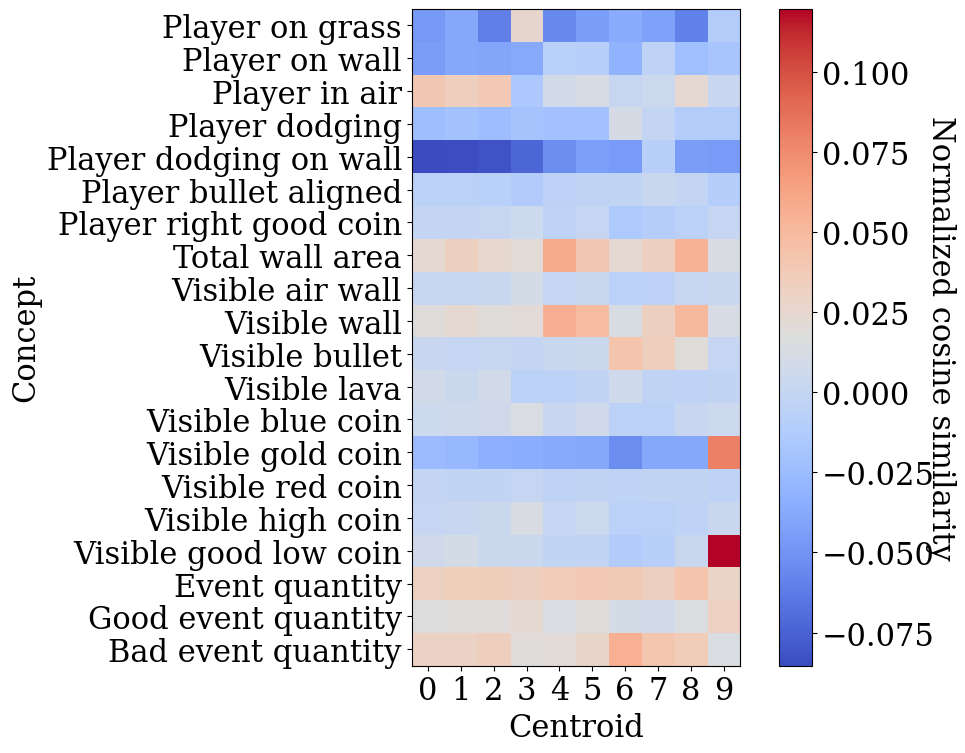

In [14]:
num_concepts = len(concept_cavs)
num_centroids = centroids.shape[0]

similarity_matrix = np.zeros((num_concepts, num_centroids))

concept_names = list(concept_cavs.keys())
centroid_names = [str(i) for i in range(num_centroids)]

for i, concept in enumerate(concept_names):
    for j in range(num_centroids):
        similarity_matrix[i, j] = cosine_similarity(concept_cavs[concept], centroids[j])

# Subtracting the row mean from each element in the row
row_means = similarity_matrix.mean(axis=1, keepdims=True)
# similarity_matrix -= row_means

# Plotting the updated similarity matrix
plt.figure(figsize=(10, 8))
plt.imshow(similarity_matrix, cmap='coolwarm', interpolation='nearest')
plt.xlabel('Centroid')
plt.ylabel('Concept')
cbar = plt.colorbar()
cbar.set_label('Normalized cosine similarity', rotation=270, labelpad=15)
# plt.title('Adjusted Concept-Centroid Cosine Similarity Matrix')
plt.xticks(np.arange(num_centroids), centroid_names)
plt.yticks(np.arange(num_concepts), concept_names)
plt.tight_layout()
plt.savefig('figures/concept centroid similarity.png', dpi=300)
plt.show()

In [10]:
plt.rcParams.update({
    'font.size': 22,
    'font.family': 'serif'
})

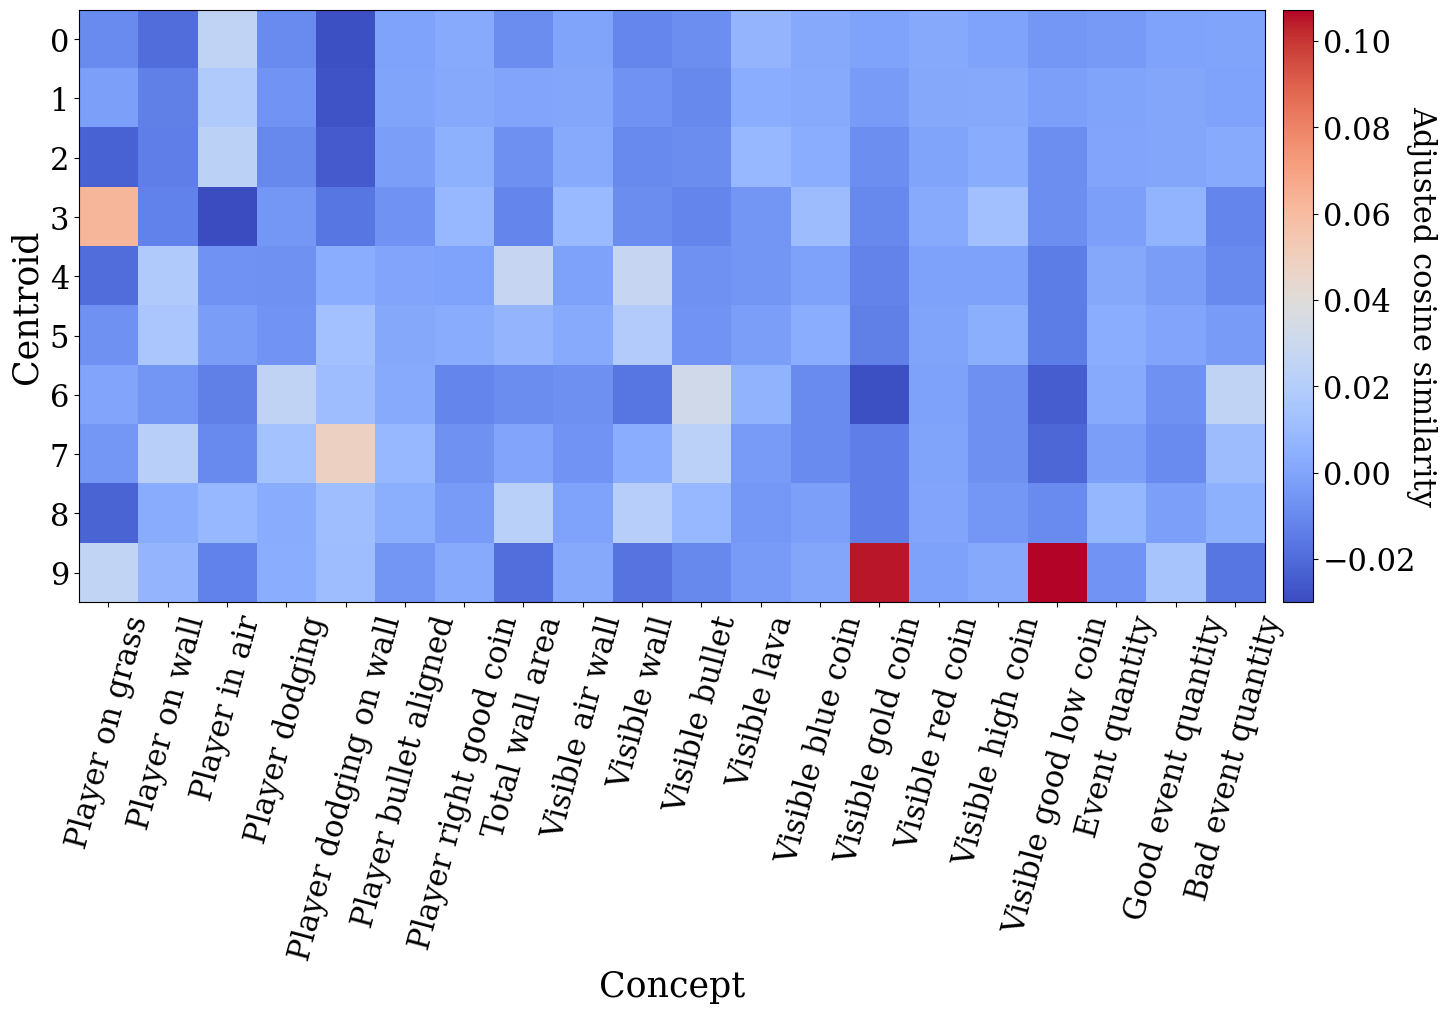

In [15]:
num_concepts = len(concept_cavs)
num_centroids = centroids.shape[0]

similarity_matrix = np.zeros((num_concepts, num_centroids))
concept_names = list(concept_cavs.keys())
centroid_names = [str(i) for i in range(num_centroids)]

for i, concept in enumerate(concept_names):
    for j in range(num_centroids):
        similarity_matrix[i, j] = cosine_similarity(concept_cavs[concept], centroids[j])

# Subtracting the row mean from each element in the row
row_means = similarity_matrix.mean(axis=1, keepdims=True)
similarity_matrix -= row_means

similarity_matrix = similarity_matrix.T

fig, ax = plt.subplots(figsize=(20, 10))
cax = ax.imshow(similarity_matrix, cmap='coolwarm')
plt.xlabel('Concept', fontsize=25)
plt.ylabel('Centroid', fontsize=25)
plt.xticks(np.arange(num_concepts), concept_names, rotation=75)
plt.yticks(np.arange(num_centroids), centroid_names)

cbar = fig.colorbar(cax, pad=0.01)
cbar.set_label('Adjusted cosine similarity', rotation=270, labelpad=15, fontsize=22)

plt.tight_layout()
plt.savefig('figures/concept discovery/concept centroid similarity.png', bbox_inches='tight')
plt.show()

Clusters 0 Concepts: ['Player in air', 'Visible lava']


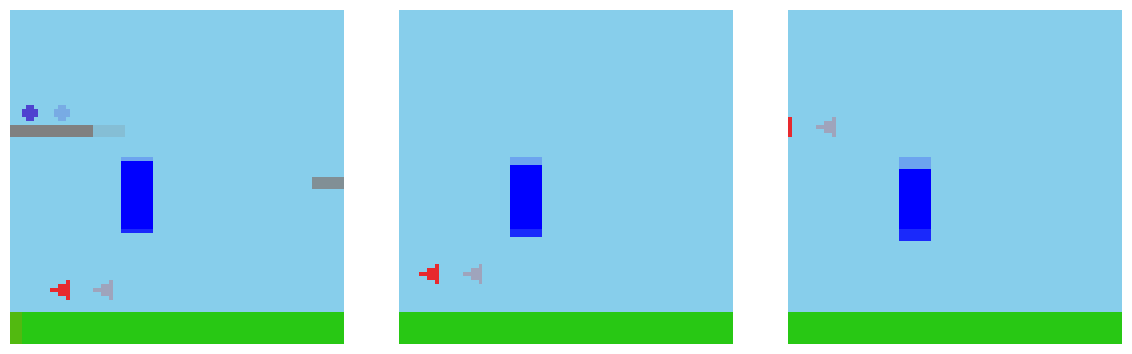

Clusters 1 Concepts: ['Player in air', 'Visible lava']


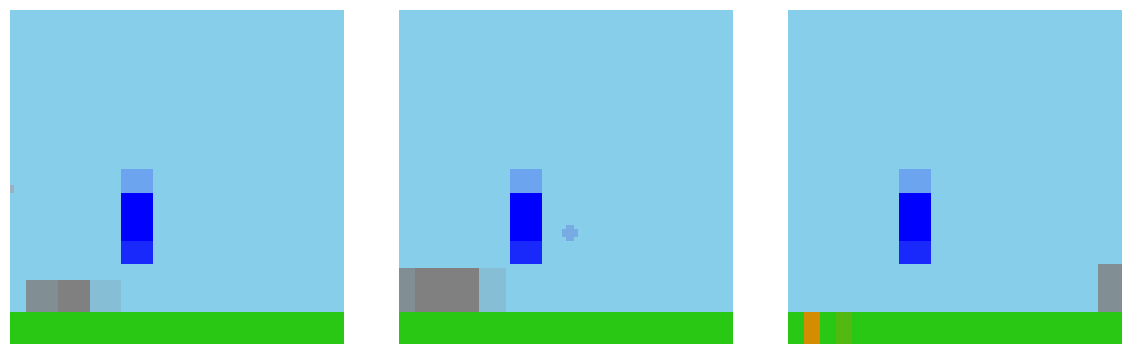

Clusters 2 Concepts: ['Player in air', 'Visible lava']


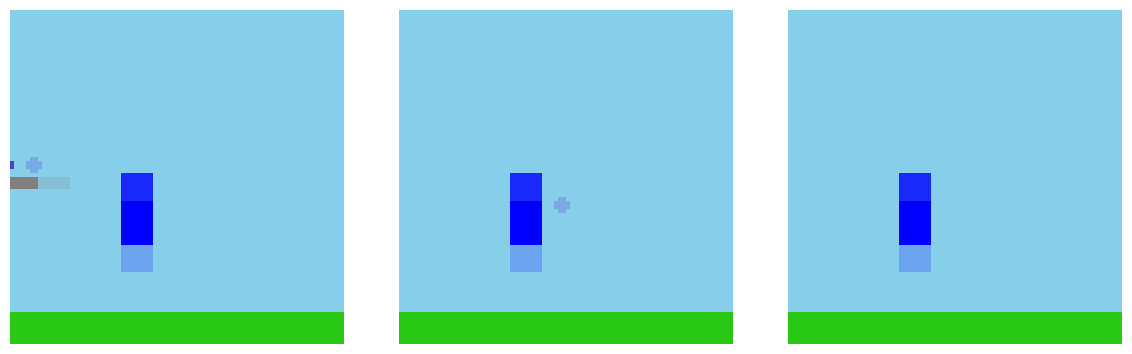

Clusters 3 Concepts: ['Player on grass', 'Visible high coin']


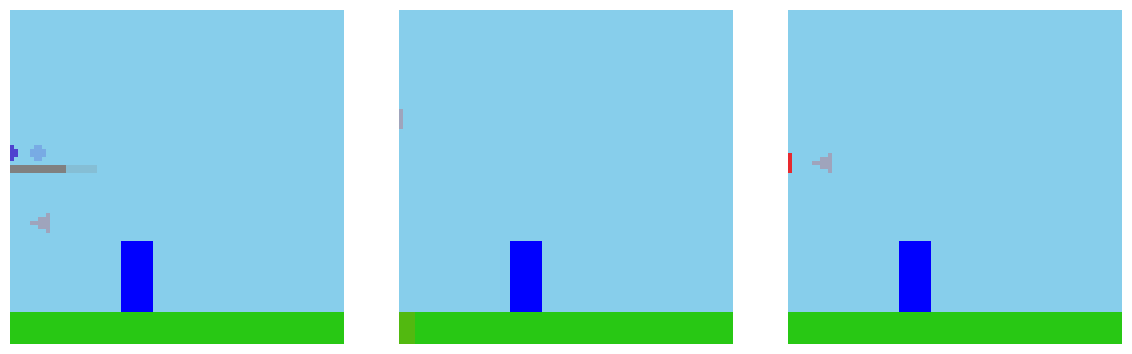

Clusters 4 Concepts: ['Visible wall', 'Total wall area']


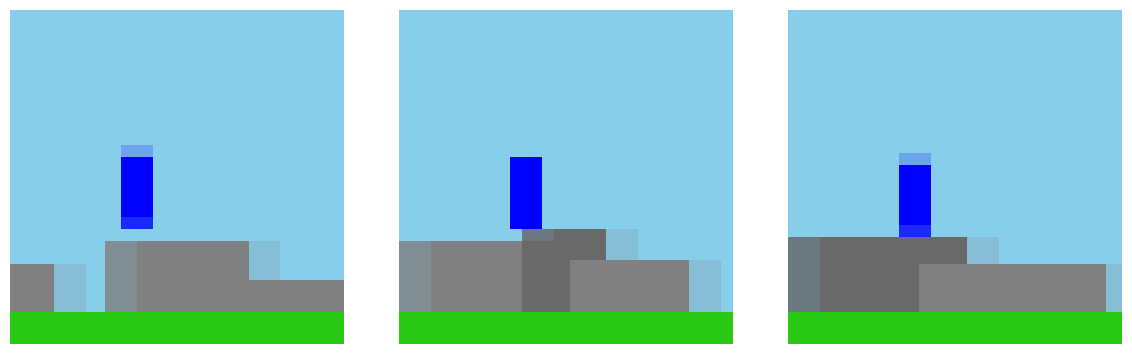

Clusters 5 Concepts: ['Visible wall', 'Player on wall']


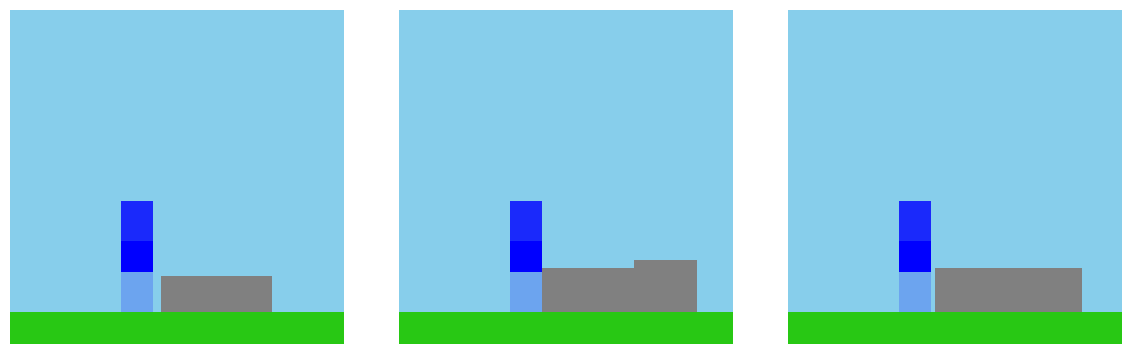

Clusters 6 Concepts: ['Visible bullet', 'Bad event quantity']


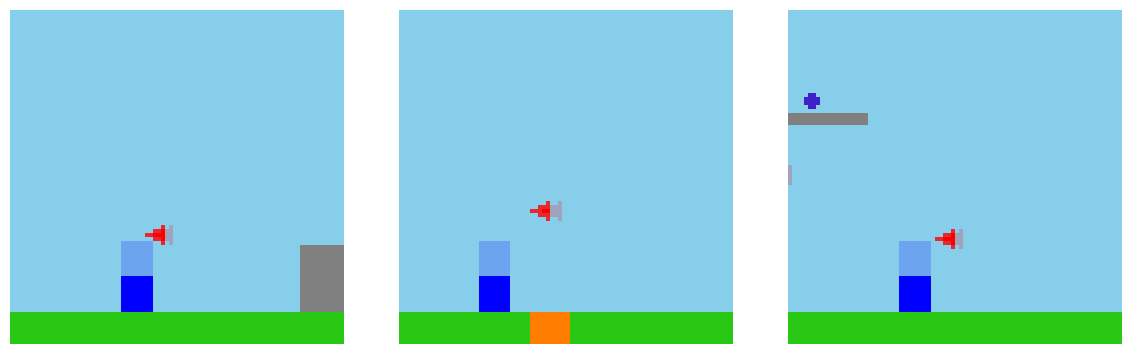

Clusters 7 Concepts: ['Player dodging on wall', 'Visible bullet']


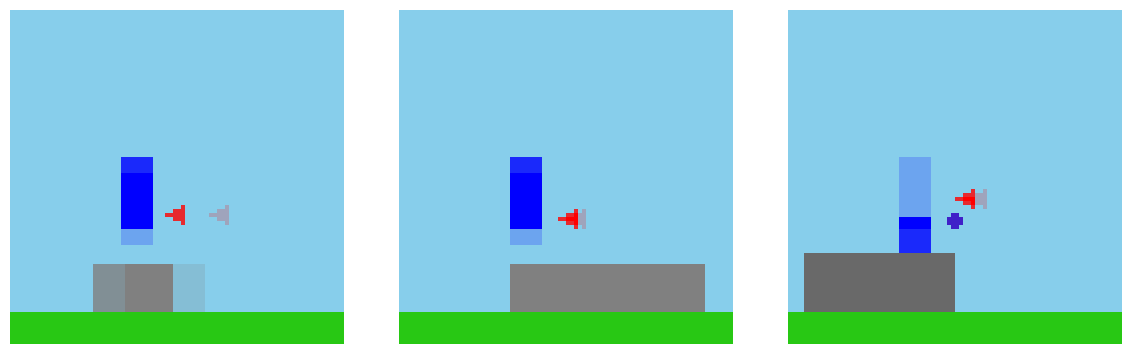

Clusters 8 Concepts: ['Total wall area', 'Visible wall']


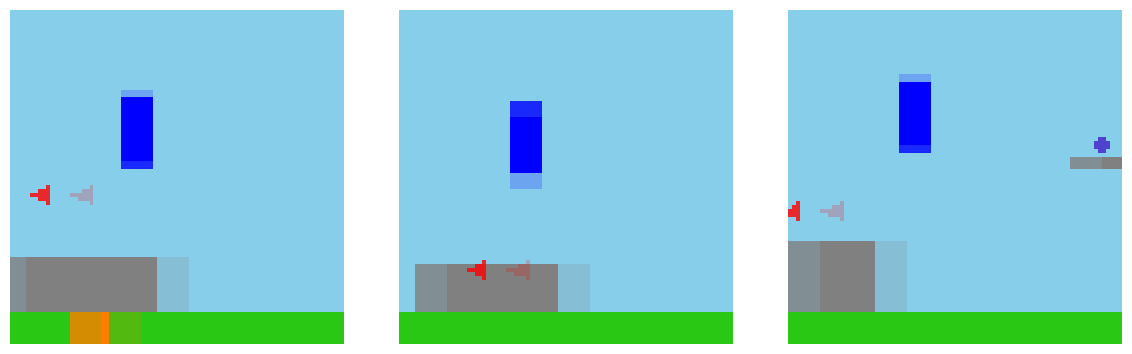

Clusters 9 Concepts: ['Visible good low coin', 'Visible gold coin']


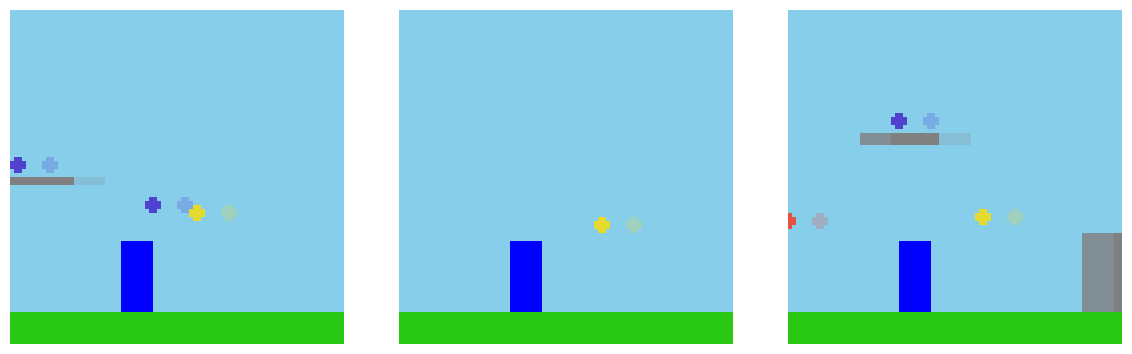

In [12]:
for i in range(K):
    #sorted_indices = np.argsort(similarity_matrix[:, i])
    #highest_concepts = [concept_names[index] for index in sorted_indices[-2:][::-1]]
    
    sorted_indices = np.argsort(similarity_matrix[i, :])
    highest_concepts = [concept_names[index] for index in sorted_indices[-2:][::-1]]
    
    print(f"Clusters {i} Concepts:", highest_concepts)

    sort_images(centroids[i], best_first=True, name=f'cluster_{i}')